# Assignment 6: Neural Networks


## 1. Backpropagation - Essentials

As you examined in class, a simple layer in a feedforward neural network can be expressed as the following:

$$h = Wx + b$$

$$t = \sigma(h)$$

$$\mathcal{L} = \frac{1}{2}(y - t)^2$$

where $x$ is the input, $W$ is the weight matrix at this node, $b$ is the bias added at the node, $\sigma(\cdot)$ is the activation function, $y$ is the label, and $\mathcal{L}$ is the loss.

The activation function and the loss function (squared loss used here) are choices made when creating a neural network. 


### a. What are the unknowns in the problem?

The unknowns are the weight matrix $W$ and the bias vector $b$.


### b. What do we want minimize?

We want to minimize the loss function.

### c. What method could we use to find the unknowns?

We can either use gradient descent or optimize with calculus (depending on the choice of loss).

### d. Find the partial derivatives of L with respect to the unknowns. 

Assume we use ReLU for the activation function.

Assume we have the following dimensions: $W \in \mathbb{R}^{m \times n}, x \in \mathbb{R}^n, b \in \mathbb{R}^m$. Then, the gradient of the loss w.r.t. to $W$ will be a tensor. Instead of computing this directly, we can calculate the partial derivatives w.r.t. to each entry in $W$:

We know that $h_i = \sum\limits_{j=1}^n W_{ij} x_j$, so $\frac{\delta h_i}{\delta W_{jk}} = \sum\limits_{l=1}^n \frac{\delta }{\delta W{jk}} W_{il} x_l$, where $\frac{\delta }{\delta W{jk}} W_{il} = 1$ if $i=j$ and $k=l$, and $0$ otherwise. 

Therefore, $(\frac{\delta h}{\delta W_{jk}})_j = x_k$, and all other elements are $0$.

Then, for $h \geq 0$: $t = h$, so
$$\frac{\delta \mathcal{L}}{\delta W} = \frac{\delta \mathcal{L}}{\delta h} \frac{\delta h}{\delta W} = -(y - Wx - b) \frac{\delta h}{\delta W}$$
where $\frac{\delta h}{\delta W}$ is the matrix with entries as specified above.

$$\frac{\delta \mathcal{L}}{\delta b} = \frac{\delta \mathcal{L}}{\delta h} \frac{\delta h}{\delta b} = -(y - Wx - b)$$

For $h < 0$: $t = 0$, so 
$$\frac{\delta \mathcal{L}}{\delta W} = 0$$
$$\frac{\delta \mathcal{L}}{\delta b} = 0$$

## 2. Backpropagation

A neural network is regarded as compositional, in that the output of one layer feeds in as the input to the next layer. Using the the same notation as above but ignoring the bias $b$ for simplicity:

$$t = \sigma_L(W_L \sigma_{L-1}(...\sigma_2(W_2 \sigma_1(W_1x))...))$$

Here $x$ is the original input data, and $t$ is the output of the neural network.

Even more simply, we can look at each layer L:

$$N_1\rightarrow N_2\rightarrow N_3\rightarrow ... N_{L-1}\rightarrow N_L $$

The idea here is the same - we will need to solve for partial derivatives for each layer to set the unknowns. As the previous layer feeds into the next, you can only solve for a Jacobian (vector of partials) one wrt one layer down e.g. we can first solve for

$$ J_{N_L} (N_{L-1})$$

the Jacobian of $N_L$ with respect to $N_{L-1}$

### a. For the above simple representation, write out the Jacobian of the the final layer with respect to the first layer.

TODO:

### b. Based on the equation you've described above, explain using time or space complexity why the best way to solve for the gradient in 2a. is to work backwards.

## 3. Simple Neural Network

Here you'll try out writing a neural network for a simple classification problem. For full credit, the final test accuracy should be above 0.6.

The dataset is of cell images from thin blood smear slides of segmented cells, with labels indicating the presence of malaria.

Source: https://lhncbc.nlm.nih.gov/publication/pub9932

Paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6544011/

Some setup to start with:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow import keras
import tensorflow_datasets as tfds
from sklearn import model_selection 

In [ ]:
malaria, info = tfds.load(name="malaria", split="train", with_info=True)
malaria = malaria.shuffle(30000).prefetch(tf.data.experimental.AUTOTUNE)
info

tfds.core.DatasetInfo(
    name='malaria',
    version=1.0.0,
    description='The Malaria dataset contains a total of 27,558 cell images
with equal instances of parasitized and uninfected cells from the thin blood 
smear slide images of segmented cells.',
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=27558,
    splits={
        'train': 27558,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward 
      improved malaria parasite detection in thin blood smear images},
      author={Rajaraman, Sivaramakrishnan and Antani, Sameer K and Poostchi, Mahdieh
      and Silamut, Kamolrat and Hossain, Md A and Maude, Richard J and Jaeger, 
      Stefan and Thoma, George R}

In [ ]:
info

tfds.core.DatasetInfo(
    name='malaria',
    version=1.0.0,
    description='The Malaria dataset contains a total of 27,558 cell images
with equal instances of parasitized and uninfected cells from the thin blood 
smear slide images of segmented cells.',
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=27558,
    splits={
        'train': 27558,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward 
      improved malaria parasite detection in thin blood smear images},
      author={Rajaraman, Sivaramakrishnan and Antani, Sameer K and Poostchi, Mahdieh
      and Silamut, Kamolrat and Hossain, Md A and Maude, Richard J and Jaeger, 
      Stefan and Thoma, George R}

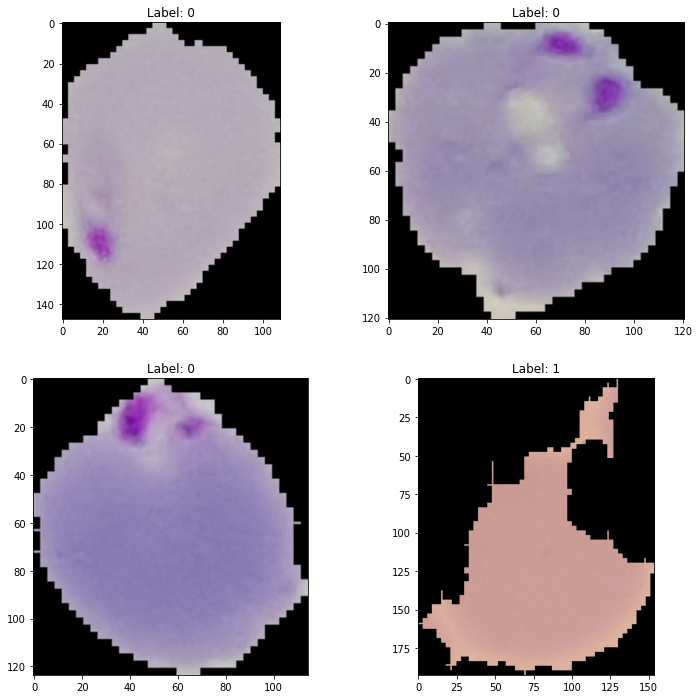

In [ ]:
# Visualize some images
plt.figure(figsize=(12,12))

for i, feature in enumerate(malaria.take(4)):
    image = feature["image"].numpy()
    label = feature["label"].numpy()
    
    plt.subplot(2, 2, i+1)
    plt.title("Label: "+str(label))
    plt.imshow(image)
    # i+=1
plt.show()

### a. Extract some samples from the malaria dataset

Hints:

* Keep the total number of samples small ( < 10000) - it largely depends on your memory (if your notebook starts to crash, reduce the number of samples and try again)
* The dimension of each image is height \* width \* 3, with the 3 representing the number of channels 
* The height and width of the images aren't all the same, so resize all of them to be 133 by 133 (see [cv2.resize](https://medium.com/@manivannan_data/resize-image-using-opencv-python-d2cdbbc480f0))
* The possibles labels are 0s and 1s (scalars)
* Split into a training and testing set (a split like 80:20 train to test is reasonable)


In [ ]:
# TODO: Initialize to the correct shapes with zeros
malaria = tfds.load("malaria", split='train[:10000]')

images = []
labels = []
dim = (133, 133)
for feature in malaria:
    images.append(cv2.resize(feature["image"].numpy(), dim) / 255)
    labels.append(feature["label"].numpy())

images = np.array(images)
labels = np.array(labels)

train_images, test_images, train_labels, test_labels = model_selection.train_test_split(images, labels, test_size=0.2, random_state=145)

### b. Add some layers to the model

Hints:

*   See examples of layers in the Keras documentation: https://keras.io/layers/core/
*   For the first layer, provide an input_shape, which refers to the shape of an image from your dataset

See examples at https://www.tensorflow.org/tutorials



In [ ]:
model = keras.Sequential([keras.Input(shape=(133, 133, 3))])

model.add(keras.layers.Conv2D(16, 3, activation='relu', padding='same'))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(32, 3, activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Conv2D(64, 3, activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D())

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(1, activation='sigmoid'))

### c. Choose how to train the above model

Pick an optimizer, loss function, and metric. If you choose something not covered in class, give a brief explanation and an advantage of your choice.

*   Optimizers: https://keras.io/optimizers/
*   Losses: https://keras.io/losses/
*   Metrics: https://keras.io/metrics/

### Reasoning:

Chose the Adam optimizer since it is "well suited for problems that are large in terms of data/parameters".

Chose binary cross entropy since we are performing binary classification -- we would not want to use loss functions better suited for regression such as mean squared error or multi-class classification losses such as general cross-entropy.

Chose the standard accuracy metric.

In [9]:
# TODO:
opt = 'adam'
loss_func = 'binary_crossentropy'
metric = 'accuracy'

In [10]:
model.compile(optimizer=opt,
              loss=loss_func,
              metrics=metric)

### d. Train the model

Choose an appropriate number of epochs (Hint: try some different values)

In [11]:
# TODO:
num_epochs = 5

model.fit(train_images, train_labels, epochs=num_epochs)

Epoch 1/5
250/250 [==============================] - 158s 626ms/step - loss: 0.1872 - accuracy: 0.9327
Epoch 2/5
250/250 [==============================] - 166s 663ms/step - loss: 0.1456 - accuracy: 0.9525
Epoch 3/5
250/250 [==============================] - 156s 625ms/step - loss: 0.1333 - accuracy: 0.9514
Epoch 4/5
250/250 [==============================] - 156s 625ms/step - loss: 0.1230 - accuracy: 0.9582
Epoch 5/5
250/250 [==============================] - 156s 623ms/step - loss: 0.1086 - accuracy: 0.9616


### e. Evaluate based on the testing set

Must be greater that 0.55 for full credit

In [12]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

63/63 - 11s - loss: 0.2735 - accuracy: 0.9275

Test accuracy: 0.9275000095367432


### f. Based on the above accuracies between the testing and training sets, did you overfit while training?

It seems like the model was overfit while training since the accuracy for the last epoch was higher than the accuracy for the training set, but not by a significant amount.


### g. (Extra Credit) Improve your model to achieve an accuracy of greater than 0.70 on the testing set.